In [1]:
import yaml
import umap

import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from carot.datasets.single_loader import CarModule
from carot.utils import score_transports_and_targets_combinations, monge_get_source_target_transport
from cmonge.utils import load_config
from cmonge.trainers.ot_trainer import MongeMapTrainer

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
default_colors = {
    "blue": "#648FFF",
    "purple": "#785EF0",
    "pink": "#DC267F",
    "orange": "#FE6100",
    "yellow": "#FFB000",
    "grey": "#DDDDDD",
}

ot_map = {
    "source": default_colors["blue"],
    "target": default_colors["pink"],
    "transport": default_colors["yellow"],
    "rest": default_colors["grey"]
}

In [3]:
features = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"

logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/notebook_logger.json"
base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/configs/"
base_ckpt_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/checkpoints/"
base_fig_save = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/transport_UMAPs/monge/"

In [4]:
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    with plt.rc_context():
    
        sc.pl.umap(sel_adata, color=["CAR_Variant", "ident", "Time", "Donor"], frameon=False, ncols=1,
                  show=False, linewidth=0)
        plt.savefig(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/transport_UMAPs/{subset}_UMAP.pdf", bbox_inches = "tight", dpi=300)
        plt.savefig(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/transport_UMAPs/{subset}_UMAP.png", bbox_inches = "tight", dpi=300)
        plt.close()

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}{subset}/NA-NA-NA_{car}_config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}NoEmbed_FuncScore_Monge_{subset}NA-NA-NA_{car}/"
        config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"

        datamodule = CarModule(config.data)
        trainer = MongeMapTrainer.load_checkpoint(
                jobid=1, config=config.model, logger_path=logger_path
            )

        size = min(len(datamodule.control_valid_cells), len(datamodule.target_valid_cells))
        all_expr, all_meta = monge_get_source_target_transport(datamodule=datamodule, trainer=trainer, batch_size=size)

        Y2 = umapper.transform(all_expr)

        all_meta[["UMAP1", "UMAP2"]] = Y2

        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=20, palette=ot_map, alpha=0.95, linewidth=0.15)
        plt.legend([],[], frameon=False)
        plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.xlabel("UMAP1", fontsize=18)
        plt.ylabel("UMAP2", fontsize=18)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.pdf", bbox_inches="tight", dpi=300)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.png", bbox_inches="tight", dpi=300)
        plt.close()

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_31607/2687602925.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-23 18:22:18.274 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:18.450 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-23 18:22:18.451 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:18.451 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:18.451 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:19.329 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD28-z


2025-08-23 18:22:25.774 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:25.781 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-23 18:22:25.781 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:25.781 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:25.781 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:25.790 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
41BB-CD40-z


2025-08-23 18:22:26.883 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:26.889 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-23 18:22:26.889 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:26.889 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:26.890 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:26.900 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
41BB-CTLA4-z


2025-08-23 18:22:28.244 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:28.249 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-08-23 18:22:28.250 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:28.250 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:28.250 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:28.259 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-IL15RA-z


2025-08-23 18:22:29.473 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:29.479 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-23 18:22:29.479 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:29.479 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:29.479 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:29.488 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
41BB-NA-z


2025-08-23 18:22:30.592 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:30.598 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-23 18:22:30.599 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:30.599 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:30.599 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:30.625 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CD28-41BB-z


2025-08-23 18:22:31.698 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:31.703 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-08-23 18:22:31.703 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:31.703 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:31.704 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:31.713 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD28-z


2025-08-23 18:22:32.854 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:32.866 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-23 18:22:32.866 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:32.884 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:32.884 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:32.892 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CD28-CD40-z


2025-08-23 18:22:33.982 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:33.988 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-23 18:22:33.988 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:33.989 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:33.989 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:33.998 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CD28-CTLA4-z


2025-08-23 18:22:35.124 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:35.129 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-08-23 18:22:35.130 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:35.130 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:35.130 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:35.139 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-IL15RA-z


2025-08-23 18:22:36.361 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:36.367 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-23 18:22:36.367 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:36.367 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:36.367 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:36.375 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CD28-NA-z


2025-08-23 18:22:37.447 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:37.453 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-23 18:22:37.453 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:37.454 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:37.454 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:37.480 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CD40-41BB-z


2025-08-23 18:22:38.532 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:38.538 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-08-23 18:22:38.538 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:38.538 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:38.538 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:38.546 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD28-z


2025-08-23 18:22:39.823 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:39.828 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-08-23 18:22:39.829 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:39.847 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:39.848 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:39.857 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD40-z


2025-08-23 18:22:41.170 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:41.175 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-08-23 18:22:41.176 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:41.176 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:41.176 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:41.184 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CTLA4-z


2025-08-23 18:22:42.456 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:42.462 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-08-23 18:22:42.462 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:42.462 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:42.463 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:42.471 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-IL15RA-z


2025-08-23 18:22:43.821 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:43.842 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-23 18:22:43.843 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:43.843 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:43.843 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:43.851 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CD40-NA-z


2025-08-23 18:22:44.890 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:44.896 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-23 18:22:44.897 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:44.897 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:44.897 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:44.906 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CTLA4-41BB-z


2025-08-23 18:22:45.977 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:45.997 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-08-23 18:22:45.997 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:45.997 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:45.998 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:46.006 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD28-z


2025-08-23 18:22:47.119 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:47.124 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-08-23 18:22:47.124 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:47.125 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:47.125 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:47.133 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD40-z


2025-08-23 18:22:48.361 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:48.366 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-08-23 18:22:48.366 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:48.367 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:48.367 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:48.375 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CTLA4-z


2025-08-23 18:22:49.495 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:49.501 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-08-23 18:22:49.501 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:49.501 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:49.501 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:49.510 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-IL15RA-z


2025-08-23 18:22:50.793 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:50.799 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-08-23 18:22:50.799 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:50.800 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:50.800 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:50.835 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-NA-z


2025-08-23 18:22:51.998 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:52.004 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-08-23 18:22:52.005 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:52.005 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:52.005 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:52.013 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
IL15RA-41BB-z


2025-08-23 18:22:52.938 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:52.944 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-23 18:22:52.944 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:52.961 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:52.961 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:52.969 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
IL15RA-CD28-z


2025-08-23 18:22:54.049 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:54.055 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-23 18:22:54.055 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:54.055 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:54.056 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:54.064 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
IL15RA-CD40-z


2025-08-23 18:22:55.141 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:55.146 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-23 18:22:55.147 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:55.147 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:55.147 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:55.155 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
IL15RA-CTLA4-z


2025-08-23 18:22:56.253 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:56.258 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-08-23 18:22:56.258 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:56.259 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:56.259 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:56.267 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-IL15RA-z


2025-08-23 18:22:57.768 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:57.775 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-23 18:22:57.775 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:57.775 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:57.776 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:57.818 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
IL15RA-NA-z


2025-08-23 18:22:58.899 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:22:58.905 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-23 18:22:58.905 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:22:58.905 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:22:58.906 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:22:58.914 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_31607/2687602925.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-23 18:23:21.824 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:21.864 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-23 18:23:21.865 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:21.865 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:21.865 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:21.873 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD28-z


2025-08-23 18:23:24.499 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:24.506 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-08-23 18:23:24.506 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:24.506 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:24.506 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:24.515 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CD40-z


2025-08-23 18:23:25.678 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:25.684 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-08-23 18:23:25.684 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:25.684 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:25.685 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:25.693 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-CTLA4-z


2025-08-23 18:23:26.778 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:26.795 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-08-23 18:23:26.795 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:26.795 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:26.796 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:26.804 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-IL15RA-z


2025-08-23 18:23:27.812 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:27.818 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-23 18:23:27.818 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:27.818 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:27.819 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:27.827 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


41BB-NA-z


2025-08-23 18:23:29.054 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:29.061 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-23 18:23:29.061 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:29.061 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:29.061 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:29.070 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-41BB-z


2025-08-23 18:23:30.282 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:30.288 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-08-23 18:23:30.288 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:30.288 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:30.289 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:30.297 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD28-z


2025-08-23 18:23:31.337 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:31.342 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-23 18:23:31.342 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:31.343 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:31.343 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:31.352 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CD40-z


2025-08-23 18:23:32.535 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:32.541 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-08-23 18:23:32.541 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:32.541 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:32.542 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:32.550 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-CTLA4-z


2025-08-23 18:23:33.721 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:33.739 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-08-23 18:23:33.739 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:33.739 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:33.740 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:33.748 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-IL15RA-z


2025-08-23 18:23:34.895 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:34.901 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-23 18:23:34.901 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:34.902 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:34.902 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:34.911 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD28-NA-z


2025-08-23 18:23:36.137 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:36.143 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-23 18:23:36.143 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:36.143 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:36.144 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:36.152 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-41BB-z


2025-08-23 18:23:37.482 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:37.487 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-08-23 18:23:37.488 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:37.488 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:37.488 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:37.496 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD28-z


2025-08-23 18:23:38.631 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:38.637 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-23 18:23:38.638 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:38.638 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:38.638 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:38.648 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CD40-z


2025-08-23 18:23:39.903 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:39.927 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-23 18:23:39.927 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:39.928 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:39.928 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:39.937 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-CTLA4-z


2025-08-23 18:23:41.214 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:41.220 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-08-23 18:23:41.220 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:41.220 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:41.220 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:41.228 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CD40-IL15RA-z


2025-08-23 18:23:42.205 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:42.211 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-08-23 18:23:42.211 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:42.212 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:42.212 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:42.236 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CD40-NA-z


2025-08-23 18:23:43.449 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:43.455 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-23 18:23:43.455 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:43.455 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:43.456 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:43.464 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-41BB-z


2025-08-23 18:23:44.897 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:44.926 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-08-23 18:23:44.926 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:44.926 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:44.927 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:44.935 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD28-z


2025-08-23 18:23:46.004 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:46.010 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-08-23 18:23:46.010 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:46.010 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:46.010 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:46.019 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-CD40-z


2025-08-23 18:23:47.092 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:47.098 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-08-23 18:23:47.098 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:47.098 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:47.098 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:47.107 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
CTLA4-CTLA4-z


2025-08-23 18:23:48.237 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:48.244 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-08-23 18:23:48.244 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:48.244 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:48.245 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:48.254 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-IL15RA-z


2025-08-23 18:23:49.343 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:49.348 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-08-23 18:23:49.349 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:49.349 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:49.349 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:49.358 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CTLA4-NA-z


2025-08-23 18:23:50.951 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:50.959 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-08-23 18:23:50.959 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:50.960 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:50.960 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:50.970 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
IL15RA-41BB-z


2025-08-23 18:23:51.931 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:51.952 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-23 18:23:51.953 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:51.953 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:51.953 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:51.962 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-CD28-z


2025-08-23 18:23:53.577 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:53.583 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-23 18:23:53.584 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:53.584 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:53.584 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:53.592 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set
IL15RA-CD40-z


2025-08-23 18:23:54.583 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:54.589 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-23 18:23:54.590 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:54.590 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:54.590 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:54.598 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-CTLA4-z


2025-08-23 18:23:55.938 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:55.957 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-23 18:23:55.957 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:55.957 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:55.958 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:55.966 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-IL15RA-z


2025-08-23 18:23:57.205 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:57.211 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-08-23 18:23:57.211 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:57.211 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:57.211 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:57.220 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


IL15RA-NA-z


2025-08-23 18:23:58.385 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:23:58.391 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-23 18:23:58.391 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:23:58.391 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:23:58.391 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:23:58.399 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# UMAP for all CAR variants

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
2025-08-23 18:24:19.673 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:19.679 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-23 18:24:19.679 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:19.679 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:19.679 | INFO     | cmonge.trainers.ot_

Evaluating on validation set


2025-08-23 18:24:21.584 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:21.590 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-23 18:24:21.590 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:21.590 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:21.591 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:21.599 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:22.280 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:22.285 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-23 18:24:22.285 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:22.285 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:22.286 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:22.294 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:22.957 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:22.962 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-08-23 18:24:22.963 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:22.963 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:22.963 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:22.972 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:23.559 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:23.564 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-23 18:24:23.564 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:23.565 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:23.565 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:23.573 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:24.253 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:24.258 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-23 18:24:24.259 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:24.259 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:24.259 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:24.267 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:24.941 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:24.946 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-08-23 18:24:24.946 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:24.946 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:24.947 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:24.955 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:25.524 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:25.530 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-23 18:24:25.530 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:25.530 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:25.530 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:25.538 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:26.218 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:26.223 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-23 18:24:26.223 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:26.223 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:26.224 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:26.232 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:26.894 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:26.899 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-08-23 18:24:26.899 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:26.899 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:26.900 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:26.908 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:27.490 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:27.496 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-23 18:24:27.496 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:27.496 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:27.497 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:27.505 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:28.175 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:28.181 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-23 18:24:28.181 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:28.181 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:28.181 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:28.190 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:28.862 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:28.868 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-08-23 18:24:28.868 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:28.868 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:28.868 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:28.877 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:29.565 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:29.571 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-08-23 18:24:29.571 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:29.571 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:29.571 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:29.580 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:30.449 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:30.455 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-08-23 18:24:30.455 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:30.455 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:30.455 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:30.464 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:31.089 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:31.094 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-08-23 18:24:31.094 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:31.094 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:31.095 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:31.103 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:31.673 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:31.678 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-23 18:24:31.678 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:31.679 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:31.679 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:31.687 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:32.341 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:32.347 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-23 18:24:32.347 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:32.347 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:32.347 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:32.356 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:33.026 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:33.032 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-08-23 18:24:33.032 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:33.032 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:33.032 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:33.041 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:33.603 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:33.608 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-08-23 18:24:33.608 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:33.609 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:33.609 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:33.617 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:34.241 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:34.246 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-08-23 18:24:34.247 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:34.247 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:34.247 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:34.256 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:34.807 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:34.812 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-08-23 18:24:34.812 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:34.812 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:34.812 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:34.821 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:35.386 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:35.391 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-08-23 18:24:35.391 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:35.392 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:35.392 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:35.400 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:35.956 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:35.961 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-08-23 18:24:35.961 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:35.961 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:35.962 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:35.970 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:36.521 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:36.526 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-23 18:24:36.526 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:36.527 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:36.527 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:36.535 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:37.199 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:37.204 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-23 18:24:37.205 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:37.205 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:37.205 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:37.213 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:37.871 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:37.876 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-23 18:24:37.877 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:37.877 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:37.877 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:37.885 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:38.547 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:38.552 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-08-23 18:24:38.552 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:38.553 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:38.553 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:38.561 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:39.170 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:39.175 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-23 18:24:39.175 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:39.175 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:39.176 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:39.184 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:24:39.835 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:24:39.840 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-23 18:24:39.841 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-23 18:24:39.841 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:24:39.841 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:24:39.849 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


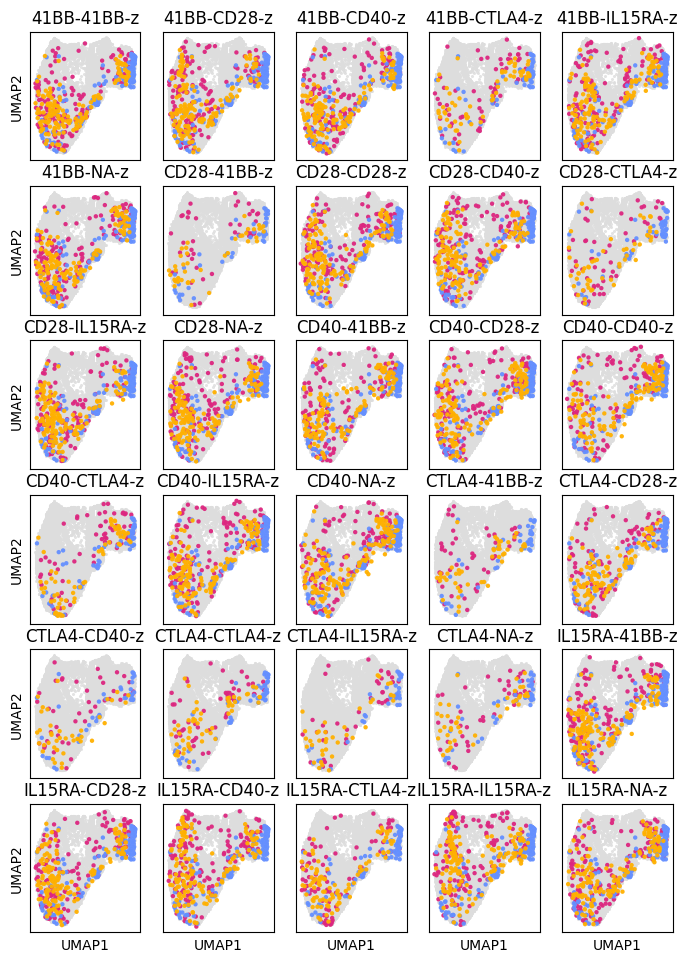

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
2025-08-23 18:25:08.767 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:08.772 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-23 18:25:08.773 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:08.773 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:08.773 | INFO     | cmonge.trainers.ot

Evaluating on validation set


2025-08-23 18:25:10.883 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:10.889 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-08-23 18:25:10.889 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:10.889 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:10.890 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:10.899 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:11.837 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:11.845 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-08-23 18:25:11.845 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:11.845 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:11.846 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:11.855 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:12.879 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:12.885 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-08-23 18:25:12.886 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:12.886 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:12.886 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:12.895 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:13.924 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:13.934 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-23 18:25:13.935 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:13.935 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:13.935 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:13.949 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:15.062 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:15.089 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-23 18:25:15.089 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:15.089 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:15.089 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:15.098 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:15.804 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:15.830 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-08-23 18:25:15.831 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:15.831 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:15.831 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:15.840 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:16.418 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:16.423 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-23 18:25:16.423 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:16.423 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:16.424 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:16.447 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:17.125 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:17.131 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-08-23 18:25:17.131 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:17.131 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:17.132 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:17.155 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:17.805 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:17.812 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-08-23 18:25:17.813 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:17.813 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:17.813 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:17.823 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-08-23 18:25:18.916 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:18.922 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-23 18:25:18.922 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:18.922 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:18.923 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:18.931 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtuale

Evaluating on validation set


2025-08-23 18:25:19.569 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:19.575 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-23 18:25:19.575 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:19.575 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:19.575 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:19.585 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:20.261 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:20.267 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-08-23 18:25:20.267 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:20.267 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:20.268 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:20.276 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:20.864 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:20.870 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-23 18:25:20.870 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:20.870 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:20.870 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:20.880 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:21.526 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:21.531 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-23 18:25:21.531 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:21.532 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:21.532 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:21.540 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:22.246 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:22.252 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-08-23 18:25:22.252 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:22.252 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:22.252 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:22.261 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:22.859 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:22.865 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-08-23 18:25:22.865 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:22.865 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:22.865 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:22.874 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:23.463 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:23.468 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-23 18:25:23.468 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:23.469 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:23.469 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:23.477 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:24.192 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:24.198 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-08-23 18:25:24.198 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:24.198 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:24.198 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:24.207 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:24.699 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:24.705 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-08-23 18:25:24.705 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:24.705 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:24.705 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:24.714 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:25.224 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:25.230 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-08-23 18:25:25.230 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:25.230 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:25.230 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:25.238 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:25.758 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:25.763 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-08-23 18:25:25.763 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:25.763 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:25.764 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:25.772 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:26.258 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:26.263 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-08-23 18:25:26.263 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:26.263 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:26.264 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:26.272 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:26.791 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:26.796 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-08-23 18:25:26.797 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:26.797 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:26.797 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:26.806 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:27.327 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:27.332 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-23 18:25:27.333 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:27.333 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:27.333 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:27.341 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:28.041 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:28.046 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-23 18:25:28.047 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:28.047 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:28.047 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:28.055 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:28.667 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:28.689 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-23 18:25:28.689 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:28.690 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:28.690 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:28.698 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:29.426 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:29.444 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-23 18:25:29.444 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:29.444 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:29.444 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:29.453 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:30.130 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:30.135 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-08-23 18:25:30.135 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:30.135 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:30.136 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:30.157 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


2025-08-23 18:25:30.736 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-23 18:25:30.742 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-23 18:25:30.742 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-23 18:25:30.742 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-23 18:25:30.742 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-23 18:25:30.762 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


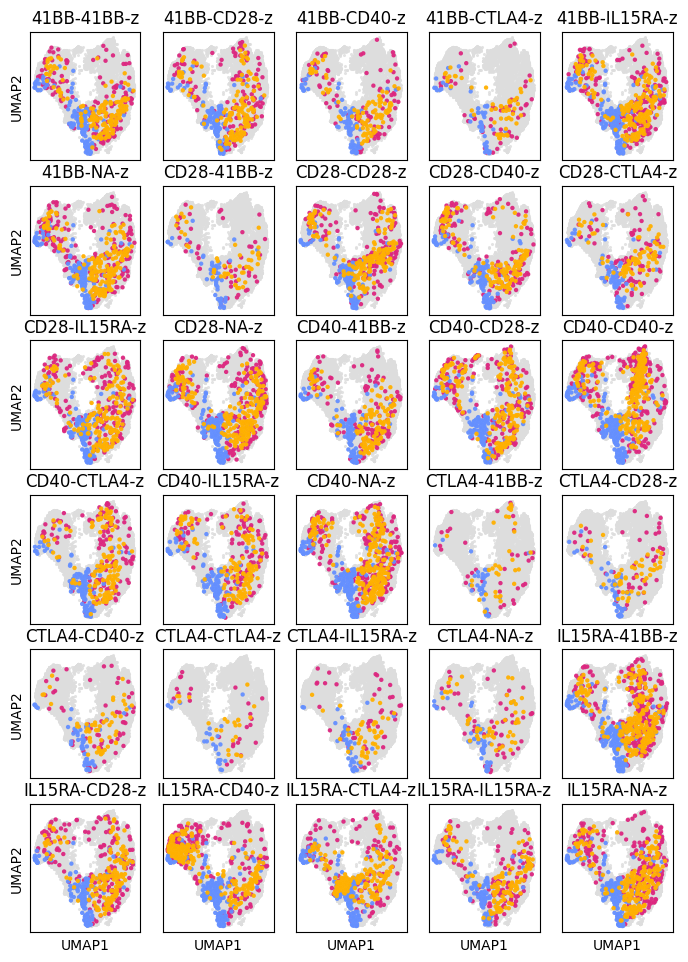

In [5]:
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)

    fig, axes = plt.subplots(nrows=6,ncols=5, sharex=True, sharey=True, figsize=(8.3, 11.7))
    flat_axes = axes.flatten()
    i =0
    for  car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        config_path = f"{base_config_path}{subset}/NA-NA-NA_{car}_config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}NoEmbed_FuncScore_Monge_{subset}NA-NA-NA_{car}/"
        config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"

        datamodule = CarModule(config.data)
        trainer = MongeMapTrainer.load_checkpoint(
                jobid=1, config=config.model, logger_path=logger_path
            )

        size = min(len(datamodule.control_valid_cells), len(datamodule.target_valid_cells))
        all_expr, all_meta = monge_get_source_target_transport(datamodule=datamodule, trainer=trainer, batch_size=size)

        Y2 = umapper.transform(all_expr)

        all_meta[["UMAP1", "UMAP2"]] = Y2

        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color=default_colors["grey"], s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.01)
        flat_axes[i].get_legend().remove()
        flat_axes[i].set_title(car)
        flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        i+=1
    plt.savefig(f"{base_fig_save}{subset}_all.pdf", bbox_inches="tight", dpi=300)
    plt.savefig(f"{base_fig_save}{subset}_all.png", bbox_inches="tight", dpi=300)
    plt.show()

In [6]:
all_meta

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,CAR_Variant,Donor,Time,Lane,Sample,...,Proinflamatory_2,Memory_3,CD4_Th1_4,CD4_Th2_5,ident,time_subset,sample_n,dtype,UMAP1,UMAP2
0,G_D17_T0,18645.0,4158,2304.0,20,IL15RA-NA-z,D17,T0,G,T0_D17,...,-0.289315,0.248432,0.214028,0.030458,CD8_Activated,early,0,target,9.230145,1.031872
1,B_D17_T0,12173.0,3158,1965.0,20,IL15RA-NA-z,D17,T0,B,T0_D17,...,2.511324,0.075792,1.025183,0.148815,CD8_Early_Cytotoxic,early,0,target,11.531477,6.629916
2,O_D09_T0,19501.0,4371,3402.0,20,IL15RA-NA-z,D09,T0,O,T0_D09,...,-0.041207,-0.042871,0.042880,-0.258878,CD8_Activated,early,0,target,8.761083,2.587168
3,G_D17_T0,16422.0,4070,2201.0,20,IL15RA-NA-z,D17,T0,G,T0_D17,...,0.308881,0.247557,-0.260234,-0.172852,CD8_Activated,early,0,target,10.631760,1.527281
4,R_D09_T12,2044.0,1085,1736.0,20,IL15RA-NA-z,D09,T12,R,T12_D09,...,-0.347145,-0.187545,-0.307711,-0.149184,Terminal,late,0,target,2.821152,3.927568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,P_D09_T0,6231.0,2118,3117.0,20,IL15RA-NA-z,D09,T0,P,T0_D09,...,0.068476,-0.184640,-0.172851,-0.198773,CD8_Activated,early,0,transport,9.511250,2.977150
692,P_D09_T0,6712.0,2267,2528.0,20,IL15RA-NA-z,D09,T0,P,T0_D09,...,-0.642867,1.055440,-0.178493,-0.192083,CD8_Resting_Memory,early,0,transport,2.202590,5.338781
693,J_D09_T6,8187.0,3287,874.0,20,IL15RA-NA-z,D09,T6,J,T6_D09,...,0.468833,-0.172042,-0.022143,-0.277570,CD8_Late_Cytotoxic,late,0,transport,9.883631,2.645287
694,P_D09_T0,9773.0,2955,3528.0,20,IL15RA-NA-z,D09,T0,P,T0_D09,...,0.306142,-0.020602,-0.097141,-0.229178,CD8_Activated,early,0,transport,8.618999,0.144775
